In [ ]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

In [ ]:
!pip install ipython-autotime

%load_ext autotime

time: 195 µs (started: 2022-03-12 13:30:21 +00:00)


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/My Drive/regression/'
os.chdir(root_path)

Mounted at /content/drive
time: 18 s (started: 2022-03-12 13:30:21 +00:00)


In [ ]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
#     print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
#             print("******************************")
#             print("Column: ",col)
#             print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            # print("dtype after: ",props[col].dtype)
            # print("******************************")
    
    # Print final result
    # print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    # print("Memory usage is: ",mem_usg," MB")
    # print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

time: 163 ms (started: 2022-03-12 13:30:39 +00:00)


In [ ]:
data_df = pd.read_csv("timeseries_dataset.csv")
data_df.fillna(0, inplace=True)
data_df, NAlist = reduce_mem_usage(data_df)
data_df.head()

,activation,batch_size,best_acc,best_loss,best_train_acc,best_train_loss,epoch,filter1,filter2,filter3,...,input_4,input_5,kernelsize_1,kernelsize_2,kernelsize_3,learning_rate,momentum,optimizer,output,p_reduct
0,relu,64,0.7965,0.595114,0.728682,0.764486,1,96,96,96,...,0.0000,0.0000,5,3,4,0.0015,0.95,adam,0.4229,0
1,relu,64,0.7965,0.595114,0.728682,0.764486,2,96,96,96,...,0.0000,0.4229,5,3,4,0.0015,0.95,adam,0.5202,0
2,relu,64,0.7965,0.595114,0.728682,0.764486,3,96,96,96,...,0.4229,0.5202,5,3,4,0.0015,0.95,adam,0.5530,0
3,relu,64,0.7965,0.595114,0.728682,0.764486,4,96,96,96,...,0.5202,0.5530,5,3,4,0.0015,0.95,adam,0.5807,0
4,relu,64,0.7965,0.595114,0.728682,0.764486,5,96,96,96,...,0.5530,0.5807,5,3,4,0.0015,0.95,adam,0.5654,0


time: 927 ms (started: 2022-03-12 13:30:39 +00:00)


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51050 entries, 0 to 51049
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   activation       51050 non-null  object 
 1   batch_size       51050 non-null  uint8  
 2   best_acc         51050 non-null  float32
 3   best_loss        51050 non-null  float32
 4   best_train_acc   51050 non-null  float32
 5   best_train_loss  51050 non-null  float32
 6   epoch            51050 non-null  uint8  
 7   filter1          51050 non-null  uint8  
 8   filter2          51050 non-null  uint8  
 9   filter3          51050 non-null  uint8  
 10  hidden_1         51050 non-null  uint8  
 11  hidden_2         51050 non-null  uint8  
 12  input_1          51050 non-null  float32
 13  input_2          51050 non-null  float32
 14  input_3          51050 non-null  float32
 15  input_4          51050 non-null  float32
 16  input_5          51050 non-null  float32
 17  kernelsize_1

In [ ]:
categorical_var = []

for _c in data_df.select_dtypes(include=['object']).columns:
    print(f"[{_c}] - No. of categories: { data_df[_c].nunique() } : { data_df[_c].unique() }")
    data_df[_c]  = pd.Categorical(data_df[_c])
    categorical_var.append(_c)

[activation] - No. of categories: 1 : ['relu']
[optimizer] - No. of categories: 1 : ['adam']
time: 54.3 ms (started: 2022-03-12 13:30:40 +00:00)


In [ ]:
df_tf = pd.get_dummies(data_df)
df_tf.head()

,batch_size,best_acc,best_loss,best_train_acc,best_train_loss,epoch,filter1,filter2,filter3,hidden_1,...,input_5,kernelsize_1,kernelsize_2,kernelsize_3,learning_rate,momentum,output,p_reduct,activation_relu,optimizer_adam
0,64,0.7965,0.595114,0.728682,0.764486,1,96,96,96,100,...,0.0000,5,3,4,0.0015,0.95,0.4229,0,1,1
1,64,0.7965,0.595114,0.728682,0.764486,2,96,96,96,100,...,0.4229,5,3,4,0.0015,0.95,0.5202,0,1,1
2,64,0.7965,0.595114,0.728682,0.764486,3,96,96,96,100,...,0.5202,5,3,4,0.0015,0.95,0.5530,0,1,1
3,64,0.7965,0.595114,0.728682,0.764486,4,96,96,96,100,...,0.5530,5,3,4,0.0015,0.95,0.5807,0,1,1
4,64,0.7965,0.595114,0.728682,0.764486,5,96,96,96,100,...,0.5807,5,3,4,0.0015,0.95,0.5654,0,1,1


time: 59.7 ms (started: 2022-03-12 13:30:40 +00:00)


In [ ]:
X = df_tf[df_tf.columns[~df_tf.columns.isin(['output'])]].values
y = df_tf['output'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

time: 27.4 ms (started: 2022-03-12 13:30:40 +00:00)


```
from hyperopt import fmin, tpe, hp
from hyperopt import STATUS_OK, Trials

def f(params):
    svr_model = SVR(kernel=params['kernel'], C=params['C'], degree=params['degree'], epsilon=params['epsilon'])
    svr_model.fit(x_train, y_train)
    svr_model_predict = svr_model.predict(x_test)
    try: r2_score(y_test, svr_model_predict)
    except: return 1000
    print(f"{r2_score(y_test, svr_model_predict)} {params}")
    return -r2_score(y_test, svr_model_predict)

space = {
    "kernel": hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    "degree": hp.randint('degree', 50),
    "C": hp.uniform('C', 0, 20),
    "epsilon": hp.loguniform('epsilon', -5, 5),
}

trials = Trials()
best = fmin(fn=f, space=space, algo=tpe.suggest, max_evals=500, trials=trials)
print(f"Best parameters: {best}")
```

In [ ]:
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(x_train, y_train)


RandomForestRegressor(n_estimators=20, random_state=0)

time: 10.8 s (started: 2022-03-12 13:30:40 +00:00)


In [ ]:
rf_y_train_predict = regressor.predict(x_test)
print("R-Squared for RF: " + str(r2_score(y_test, rf_y_train_predict)))

R-Squared for RF: 0.8005762769815628
time: 169 ms (started: 2022-03-12 13:33:19 +00:00)


In [ ]:
rmse = mean_squared_error(y_test, regressor.predict(x_test), squared=False)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))

The root mean squared error (RMSE) on test set: 0.0357
time: 122 ms (started: 2022-03-12 13:33:26 +00:00)


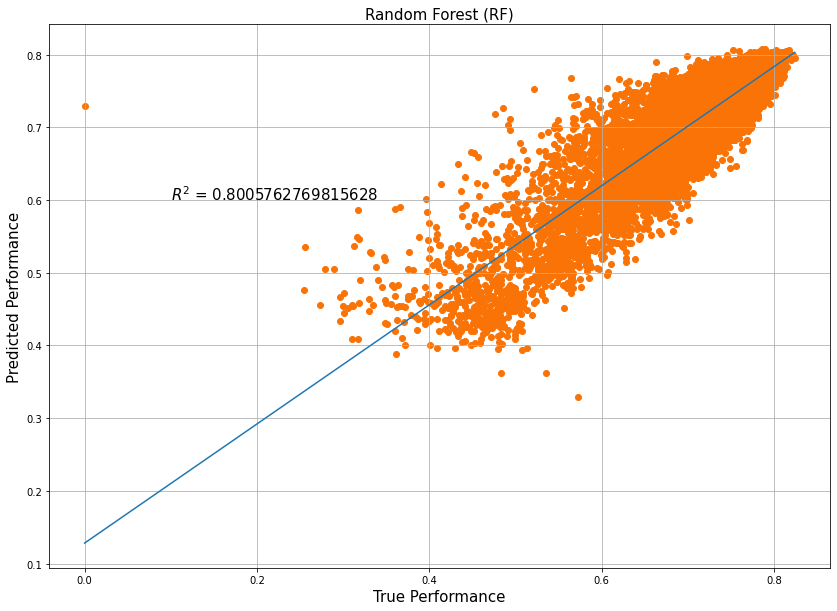

time: 660 ms (started: 2022-03-12 13:33:29 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))

Y = y_test
Y_pred = regressor.predict(x_test)

r_squared = r2_score(Y, Y_pred)
#r_squared = 0.81
plt.scatter(Y,Y_pred, c='xkcd:orange')
plt.xlabel('True Performance',  fontsize=15)
plt.ylabel('Predicted Performance', fontsize=15)
plt.title("Random Forest (RF)", fontsize=15)

plt.plot(np.unique(Y), np.poly1d(np.polyfit(Y, Y_pred, 1))(np.unique(Y)))

plt.text(0.1, 0.6, f"$R^2$ = {r_squared}", fontsize=15)
plt.grid(True)
plt.show()

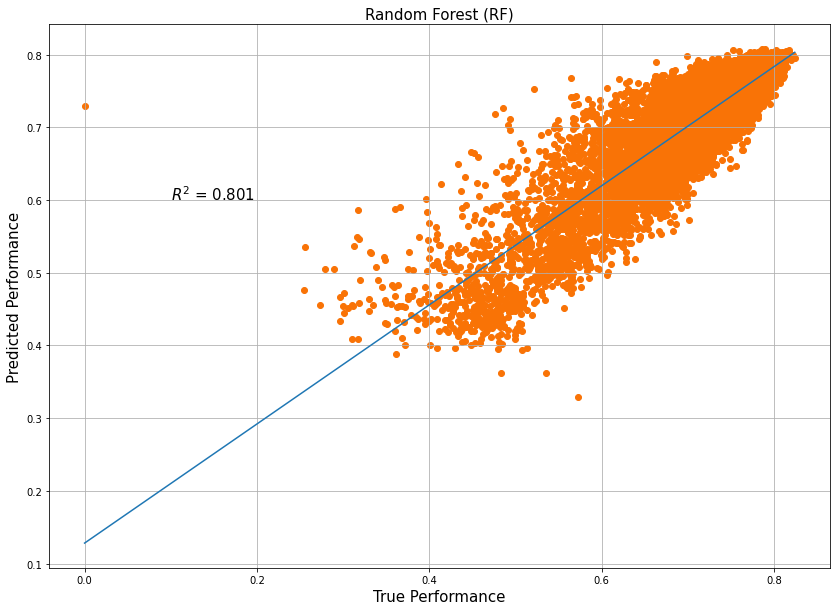

time: 415 ms (started: 2022-03-12 13:48:05 +00:00)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))

Y = y_test
Y_pred = regressor.predict(x_test)

#r_squared = r2_score(Y, Y_pred)
r_squared = 0.801
plt.scatter(Y,Y_pred, c='xkcd:orange')
plt.xlabel('True Performance',  fontsize=15)
plt.ylabel('Predicted Performance', fontsize=15)
plt.title("Random Forest (RF)", fontsize=15)

plt.plot(np.unique(Y), np.poly1d(np.polyfit(Y, Y_pred, 1))(np.unique(Y)))

plt.text(0.1, 0.6, f"$R^2$ = {r_squared}", fontsize=15)
plt.grid(True)
plt.show()